### Assignment: Feature Engineering

Create the following features and determine if they improve model accuracy. 

1. Create 2nd and 3rd order polynomial columns for 'hd'
2. Then, try combining the 'cd' and 'multi' features: If 'cd' AND 'multi' both equal "yes" then 1, else 0.
3. Finally, bin ram values into '<=4', '8', and '16+' - does this improve model fit?
4. Create Dummy Variables for any categorical columns

Remove any features that don't improve model accuracy and score your final model on the test dataset.

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np

computers = pd.read_csv("../Data/Computers.csv")
computers.tail()

,price,speed,hd,ram,screen,cd,multi,premium,ads,trend
6254,1690,100,528,8,15,no,no,yes,39,35
6255,2223,66,850,16,15,yes,yes,yes,39,35
6256,2654,100,1200,24,15,yes,no,yes,39,35
6257,2195,100,850,16,15,yes,no,yes,39,35
6258,2490,100,850,16,17,yes,no,yes,39,35


### Feature Engineering

In [2]:
ram_dict = {
    2: "<=4",
    4: "<=4",
    8: "8",
    16: "16+",
    24: "16+",
    32: "16+"
}

computers_eng = (
    pd.get_dummies(
        computers.assign(
            hd2 = computers['hd'] **2,
            hd3 = computers['hd'] **3,
            #ports = np.where((computers['cd'] == "yes") & (computers['multi'] == "yes"), 1, 0), # Decreased our score, bad feature
            #ram_categories = computers['ram'].map(ram_dict), # bad feature
        )#.drop(['ram'], axis=1) # we need this back since testing new feature failed
        ,
    drop_first=True
    ).astype(int)
)

computers_eng.head()

,price,speed,hd,ram,screen,ads,trend,hd2,hd3,cd_yes,multi_yes,premium_yes
0,1499,25,80,4,14,94,1,6400,512000,0,0,1
1,1795,33,85,2,14,94,1,7225,614125,0,0,1
2,1595,25,170,4,15,94,1,28900,4913000,0,0,1
3,1849,25,170,8,14,94,1,28900,4913000,0,0,0
4,3295,33,340,16,14,94,1,115600,39304000,0,0,1


### Data Splitting

In [3]:
from sklearn.model_selection import train_test_split

# Original model & feature set below
features = ["speed", "hd", "ram", "screen", "ads", "trend"]

X = sm.add_constant(computers_eng.drop('price', axis=1))
#X = sm.add_constant(computers[features])
y = np.log(computers["price"])

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

### Cross-Validation

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as mae

kf = KFold(n_splits=5, shuffle=True, random_state=2023)

# Create a list to store validation scores for each fold
cv_lm_r2s = []
cv_lm_mae = []

# Loop through each fold in X and y
for train_ind, val_ind in kf.split(X, y):
    #Subset data based on CV folds
    X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
    X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]

    # Fit the model on fold's training data
    model = sm.OLS(y_train, X_train).fit()

    # Append Validation score to list
    cv_lm_r2s.append(r2(y_val, model.predict(X_val),))
    cv_lm_mae.append(mae(y_val, model.predict(X_val),))

print("All Validation R2s: ", [round(x,3) for x in cv_lm_r2s])
print(f"Cross Val R2s: {round(np.mean(cv_lm_r2s), 3)} +- {round(np.std(cv_lm_r2s), 3)}")

print("All Validation MAEs: ", [round(x, 3) for x in cv_lm_mae])
print(f"Cross Val MAEs: {round(np.mean(cv_lm_mae), 3)} +- {round(np.std(cv_lm_mae), 3)}")

All Validation R2s:  [0.803, 0.79, 0.806, 0.811, 0.797]
Cross Val R2s: 0.801 +- 0.007
All Validation MAEs:  [0.086, 0.091, 0.088, 0.087, 0.088]
Cross Val MAEs: 0.088 +- 0.002


In [5]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0], alpha=.3)
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   


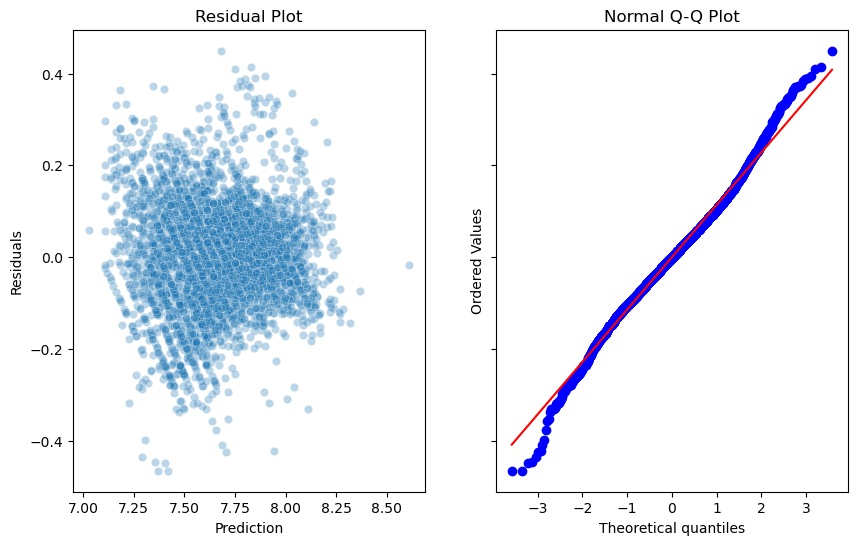

In [6]:
residual_analysis_plots(model)

### Fit On All Training Data

In [7]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     1849.
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:54:09   Log-Likelihood:                 3757.8
No. Observations:                5007   AIC:                            -7492.
Df Residuals:                    4995   BIC:                            -7413.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.8493      0.028    245.333      0.000       6.795       6.904
speed           0.0040   8.65e-05     46.463      0.000       0.004       0.004
hd              0.0008   2.57e-05     32.206      0.000       0.001       0.001
ram             0.0206      0.001     40.649      0.000       0.020       0.022
screen          0.0501      0.002     27.064      0.000       0.046       0.054
ads             0.0002   2.45e-05      6.836      0.000       0.000       0.000
trend          -0.0243      0.000    -81.454      0.000      -0.025      -0.024
hd2         -3.304e-07   1.72e-08    -19.189      0.000   -3.64e-07   -2.97e-07
hd3         -7.411e-11   8.54e-12     -8.675      0.000   -9.09e-11   -5.74e-11
cd_yes          0.0394      0.004      8.893      0.000       0.031       0.048
multi_yes       0.0486      0.005      9.164      0.000       0.038       0.059
premium_yes    -0.2429      0.006    -42.183      0.000      -0.254      -0.232
==============================================================================
Omnibus:                       91.946   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.158
Skew:                           0.085   Prob(JB):                     2.06e-39
Kurtosis:                       3.908   Cond. No.                     5.96e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Test Performance

In [8]:
print(f"Test R2: {r2(y_test, model.predict(X_test))}")
print(f"Test MAE: {mae(y_test, model.predict(X_test))}")

Test R2: 0.8065658815043161
Test MAE: 0.08779069040050624
